# Implementing L1Offset in coffea

In [9]:
from coffea import  processor
from coffea.analysis_objects import JaggedCandidateArray
import time
import uproot
import uproot_methods
import awkward
import numpy as np
import coffea.hist as hist
from scipy import stats
from scipy.ndimage.interpolation import shift
from scipy import ndimage
from numba import jit
import pandas as pd

#### getWeights function to calculate the weights for MC histograms.
It takes the data and MC TTree as input and calculates the weights by taking the ratio of the pileup profiles and normalising it to have max value 1. These weights are applied only to MC histograms to reweight the MC wrt Data.

In [10]:
def getWeights(data, MC):
    """get array weights for the dataset"""
    stime = time.time()
    #cia h_weights, bins = np.histogram(data.array("mu"), bins=np.arange(0,100.1, 0.5))
    #cia h_weights_mc, bins = np.histogram(MC.array("mu"), bins=np.arange(0,100.1, 0.5))
    h_weights, bins = np.histogram(data.array("mu"), bins=np.linspace(0, 100, 200+1))
    h_weights_mc, bins = np.histogram(MC.array("mu"), bins=np.linspace(0, 100, 200+1))  
    ratio = np.where(h_weights_mc>0., h_weights/h_weights_mc, 0)
    weight = ratio / np.max(ratio)
    print(time.time()-stime)
    return weight

In [11]:
etabins=np.array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839, -3.664, -3.489, -3.314, -3.139, -2.964,
         -2.853, -2.65, -2.5, -2.322, -2.172, -2.043, -1.93, -1.83, -1.74, -1.653, -1.566, -1.479, -1.392, -1.305,
         -1.218, -1.131, -1.044, -0.957, -0.879, -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
         -0.087, 0, 0.087, 0.174, 0.261, 0.348, 0.435, 0.522, 0.609, 0.696, 0.783, 0.879, 0.957, 1.044, 1.131,
         1.218, 1.305, 1.392, 1.479,1.566, 1.653, 1.74, 1.83, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853, 2.964,
         3.139, 3.314, 3.489, 3.664, 3.839, 4.013, 4.191, 4.363, 4.538, 4.716, 4.889, 5.191])
nEta = 82
etaC=0.5*(etabins[:-1]+etabins[1:])
mucut = 0
def calcGeometricOffset(rCone, E, f_id, mu):
    E = (E.flatten()).reshape(len(E),nEta)[mu>mucut]
    f_id = (f_id.flatten()).reshape(len(f_id),nEta)[mu>mucut]
    if (len(f_id)!=len(E)):
        print("Error")
    area = 2* np.pi * (etabins[1:] - etabins[:-1])
    
    #cia
    xx = E*f_id*np.pi*rCone*rCone / 255. / np.cosh(etaC) / area
    print("return shape", xx.shape)
    #cia end
    
    return E*f_id*np.pi*rCone*rCone / 255. / np.cosh(etaC) / area

In [12]:
def calcOffsetRC(rCone, E, f_id):
    E = (E.flatten()).reshape(len(E),nEta)
    f_id = (f_id.flatten()).reshape(len(f_id),nEta)
    k = np.zeros((21,82))
    offset_id = np.zeros(E.shape)
    for ieta in range(len(etaC)):
        # first calculating area depending on etaC
        etaL_eta = etabins[:-1] - etaC[ieta]
        etaR_eta = etabins[1: ] - etaC[ieta]
        d1 = np.where(np.abs(etaL_eta)>np.abs(etaR_eta), np.abs(etaR_eta), np.abs(etaL_eta))
        d2 = np.where(np.abs(etaL_eta)>np.abs(etaR_eta), np.abs(etaL_eta), np.abs(etaR_eta))
        A1 = np.where(d1<=rCone, 0.5*rCone*rCone*(2*np.arccos(d1/rCone) - np.sin(2*np.arccos(d1/rCone))), 0 )
        A2 = np.where(d2<=rCone, 0.5*rCone*rCone*(2*np.arccos(d2/rCone) - np.sin(2*np.arccos(d2/rCone))), 0 )
        area = np.where((etaL_eta*etaR_eta>0), A1-A2, (np.pi*rCone*rCone)-A1-A2)
        area[(etaL_eta*etaR_eta>0) & (np.abs(etaL_eta)>rCone) & (np.abs(etaR_eta)>rCone)]=0
        
        x1 = np.where(np.abs(etaL_eta)>rCone, np.copysign(rCone,etaL_eta), etaL_eta)
        x2 = np.where(np.abs(etaR_eta)>rCone, np.copysign(rCone,etaR_eta), etaR_eta)
        dphi = np.sqrt(rCone**2 - (0.5*(x1+x2))**2)
        dphi[(etaL_eta*etaR_eta>0) & (np.abs(etaL_eta)>rCone) & (np.abs(etaR_eta)>rCone)]=0
        dphi = np.where(dphi > 0.000001, np.sin(dphi)/dphi, 1)
        
        A = area * dphi / (2* np.pi * (etabins[1:] - etabins[:-1]))/ np.cosh(etaC[ieta])
        
        if (ieta>=0 and ieta <=10):
            k[:,ieta] = np.pad(A[0:ieta+11], (10-ieta, 0), 'constant', constant_values=(0, 0))
        elif (ieta>10 and ieta <=71):
            k[:,ieta] = A[ieta-10:ieta+11]
            #k = np.vstack((k, A[ieta-10:ieta+11]))
        elif (ieta>71):
            k[:,ieta] = np.pad(A[ieta-10:], (0, 11-(82-ieta)), 'constant', constant_values=(0, 0))

        # Now Calculating offset
        x = ndimage.convolve(E*f_id, k[:,ieta].reshape(1,21), mode='constant')
        if (ieta>=0 and ieta <=10):
            x[:,ieta+11:]=0
        elif (ieta>10 and ieta <=71):
            x[:,:ieta-10]=0
            x[:,ieta+11:]=0
            x[:,ieta-10:ieta+11]
        elif (ieta>71):
            x[:,:ieta-10]=0
        offset_id += x
    return offset_id

In [14]:
data = uproot.open('../../OffsetUL17_withJEC/Total_Data_UL2017_skimmed.root')["T"]
MC = uproot.open('../../OffsetUL17_withJEC/Total_MC_UL2017_skimmed.root')["T"]

#cia  
data.show()
print("data: len(energy) = ", len(data.array("energy")))
print("data: 82 energy entries in each event --", (data.array("energy").counts == 82).any())
print("mc: len(energy) = ", len(MC.array("energy")))
print("mc: 82 energy entries in each event -- ", (MC.array("energy").counts == 82).any())
#cia end
 

run                        (no streamer)              asdtype('>i4')
lumi                       (no streamer)              asdtype('>i4')
bx                         (no streamer)              asdtype('>i4')
event                      (no streamer)              asdtype('>u8')
mu                         (no streamer)              asdtype('>f4')
mua                        (no streamer)              asdtype("('>i4', (16,))")
puz                        (no streamer)              asdtype("('>f4', (50,))")
rho                        (no streamer)              asdtype('>f4')
rhoC0                      (no streamer)              asdtype('>f4')
rhoCC                      (no streamer)              asdtype('>f4')
nPVall                     (no streamer)              asdtype('>i4')
nPV                        (no streamer)              asdtype('>i4')
pv_ndof                    (no streamer)              asjagged(asdtype('>f4'))
pv_z                       (no streamer)              asjagged(asdtype(

In [15]:
weights = getWeights(data, MC)

#cia 
print("len(weights) = ", len(weights))
print("maximum weight", np.max(weights))
#print(np.argmax(weights))
print(weights)
#cia end

0.03416013717651367
len(weights) =  200
maximum weight 1.0
[2.82608696e-01 2.50000000e-01 1.73913043e-01 0.00000000e+00
 1.73913043e-01 1.35869565e-01 0.00000000e+00 0.00000000e+00
 1.25000000e-01 2.00000000e-01 9.78260870e-02 1.00000000e+00
 7.17391304e-01 1.30434783e-01 1.08695652e-01 1.41304348e-01
 1.73913043e-01 9.05797101e-02 5.50724638e-02 1.52173913e-01
 8.11036789e-02 4.71014493e-02 5.89464883e-02 1.29598662e-01
 7.48517787e-02 6.07580825e-02 6.35451505e-02 7.05533597e-02
 5.32233883e-02 8.21739130e-02 5.82076309e-02 6.20969420e-02
 5.71506699e-02 6.77388578e-02 6.11550285e-02 7.93053194e-02
 6.70694065e-02 7.36541380e-02 6.58140055e-02 7.67944430e-02
 6.85080165e-02 7.68329071e-02 7.77815817e-02 6.79107349e-02
 7.47699143e-02 6.57812304e-02 6.12567004e-02 5.93738646e-02
 5.39412339e-02 6.26633405e-02 6.09229128e-02 6.70215912e-02
 6.65967778e-02 7.14285714e-02 6.36704120e-02 6.91222753e-02
 6.88893619e-02 6.34438652e-02 5.57971014e-02 5.38512470e-02
 5.89378626e-02 5.80191952

/usr/local/bin/start_ipykernel.py:8: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/bin/start_ipykernel.py:8: RuntimeWarning: invalid value encountered in true_divide


In [25]:
class Histomaker(processor.ProcessorABC):
    def __init__(self, weights=[]):
        self.R = 0.4
        self._weights = weights # np.ones(200) # weights
        self.MAXNPV = 100
        self.MAXNPU = 100
        self.MAXRHO = 100
        self.nEta = 82
        self.etabins = np.array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839, -3.664,
                                 -3.489, -3.314, -3.139, -2.964, -2.853, -2.65, -2.5, -2.322, -2.172,
                                 -2.043, -1.93, -1.83, -1.74, -1.653, -1.566, -1.479, -1.392, -1.305,
                                 -1.218, -1.131, -1.044, -0.957, -0.879, -0.783, -0.696, -0.609, -0.522,
                                 -0.435, -0.348, -0.261, -0.174, -0.087, 0, 0.087, 0.174, 0.261, 0.348,
                                 0.435, 0.522, 0.609, 0.696, 0.783, 0.879, 0.957, 1.044, 1.131,1.218,
                                 1.305, 1.392, 1.479,1.566, 1.653, 1.74, 1.83, 1.93, 2.043, 2.172,
                                 2.322, 2.5, 2.65, 2.853, 2.964, 3.139, 3.314, 3.489, 3.664, 3.839,
                                 4.013, 4.191, 4.363, 4.538, 4.716, 4.889, 5.191])

        dataset_axis = hist.Cat("dataset", "Dataset")
        flavor_axis = hist.Cat("flavor", "PF Flavor")
        nPU_axis = hist.Bin("nPU", "mu",  2*self.MAXNPU, 0, self.MAXNPU)
        nPV_axis = hist.Bin("nPV", "nPV", 2*self.MAXNPV, 0, self.MAXNPV)
        rho_axis = hist.Bin("rho", "rho", 2*self.MAXRHO, 0, self.MAXRHO)        
        eta_axis = hist.Bin("eta", "eta", self.etabins)
        
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nPU": hist.Hist("Events", dataset_axis, nPU_axis ),
            "nPV": hist.Hist("Events", dataset_axis, nPV_axis),
            "rho": hist.Hist("Events", dataset_axis, rho_axis),
            
            #cia 
            "p_nPV_nPU": hist.Hist("Events", dataset_axis, nPU_axis ),
 #          "p_eta_nPU_flavor":       hist.Hist("Events", dataset_axis, flavor_axis, nPU_axis,  eta_axis),
            "p_mikko_eta_nPU_flavor": hist.Hist("Events", dataset_axis, flavor_axis, nPU_axis,  eta_axis),
            #cia end
            
#             "offsetpT_geo_eta_nPU":processor.defaultdict_accumulator(float),
#             "geo_nEvents":processor.defaultdict_accumulator(int),
#             "offsetpT_eta_nPU":processor.defaultdict_accumulator(float),
#             "RC_nEvents":processor.defaultdict_accumulator(int),         
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        output["sumw"][dataset] += df.size

        mu = df['mu']
        rho = df['rho']
        nPV = df['nPV']
        #cia prints:
        print("==> iside Processor")
        print("  df.size = ", df.size)
        print("  len(mu) = ", len(mu))
       
        weight = np.ones_like(mu)
        if (dataset=='MC'):
            #cia index = np.digitize(mu,np.arange(0,self.MAXNPU+0.1,0.5))
            index = np.digitize(mu,np.linspace(0, 100, 200+1))
            weight = weights[index-1]
           
        output["nPU"].fill(dataset=dataset, nPU=mu.flatten(), weight=weight)
        output["p_nPV_nPU"].fill(dataset=dataset, nPU=mu.flatten(),  weight=weight*nPV.flatten())
        output["nPV"].fill(dataset=dataset, nPV=nPV.flatten(), weight=weight)
        output["rho"].fill(dataset=dataset, rho=rho.flatten(), weight=weight)
                    
        ## All good so far -- Working on calculating geometric and RC offset inside the coffea processor. 

        energy = df['energy']
        print("  len(energy)", len(energy))
        ids = ['fchm', 'fchu', 'fnh', 'fne', 'fhfh', 'fhfe', 'flep', 'funtrk']
        
        ## Calculating geometric offset - output shape is (100,82) for each particle type.
        geo_nEvents= np.histogram(mu[mu>mucut],bins=np.arange(101))
        mu_bin_geo = np.digitize((mu+0.5).astype(int),bins=np.arange(101))[mu>mucut]
        offsetpT_geo_eta_nPU = np.zeros((len(ids),100,self.nEta))
        etaC=0.5*(self.etabins[:-1]+self.etabins[1:])
        for i in range(len(ids)):
          #cia 
          geo_offset = calcGeometricOffset(self.R, energy, df[ids[i]],mu )
          #cia offsetpT_geo_eta_nPU[i][mu_bin_geo] += ((calcGeometricOffset(self.R, energy, df[ids[i]],mu ))*
          #cia                            np.repeat(weight[mu>mucut],self.nEta).reshape(len(weight[mu>mucut]),self.nEta))
#cia          offsetpT_geo_eta_nPU[i][mu_bin_geo] += np.ones((self.nEta)) #geo_offset
#           output["offsetpT_geo_eta_nPU"][dataset][i] += offsetpT_geo_eta_nPU
          for ieta in range(self.nEta):      
#           output["p_eta_nPU_flavor"].fill(dataset=dataset, flavor=ids[i], nPU=mu.flatten(), eta=etaC[ieta], weight=weight)           
            weight_offset = geo_offset[:,ieta]*weight                      
            output["p_mikko_eta_nPU_flavor"].fill(dataset=dataset, flavor=ids[i], nPU=mu.flatten(), eta=etaC[ieta], weight=weight_offset) 
        
#         output["geo_nEvents"][dataset] += geo_nEvents[0]
#         output["offsetpT_geo_eta_nPU"][dataset] += offsetpT_geo_eta_nPU
        
        ## Calculating RC offset - output shape is (100,82) for each particle type.
        RC_nEvents= np.histogram(mu,bins=np.arange(101))
        mu_bin = np.digitize((mu+0.5).astype(int),bins=np.arange(101))
        offsetpT_eta_nPU = np.zeros((len(ids),100,self.nEta))
        for i in range(len(ids)):
            offsetpT_eta_nPU[i][mu_bin] += ((calcOffsetRC(self.R, energy, df[ids[i]]))*
                                        np.repeat(weight,self.nEta).reshape(len(weight),self.nEta))
        #print(offsetpT_eta_nPU.shape)
#         output["RC_nEvents"][dataset] += RC_nEvents[0]
#         output["offsetpT_eta_nPU"][dataset] += offsetpT_eta_nPU
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [26]:
fileset = {
    'Data': ['../../OffsetUL17_withJEC/Total_Data_UL2017_skimmed.root'],
    'MC': [ '../../OffsetUL17_withJEC/Total_MC_UL2017_skimmed.root']
}

output = processor.run_uproot_job(
    fileset,
    treename="T",
    processor_instance=Histomaker(weights=weights),
    executor=processor.futures_executor,
    executor_args={'workers':2},
    chunksize=10000,
#    maxchunks=1,
)

==> iside Processor
  df.size =  10160
  len(mu) =  10160
==> iside Processor
  df.size =  10160
  len(mu) =  10160
  len(energy) 10160
return shape (10160, 82)
  len(energy) 10160
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


return shape (10160, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10160
  len(mu) =  10160
  len(energy) 10160
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10160, 82)
==> iside Processor
  df.size =  10159
  len(mu) =  10159
return shape (10160, 82)
  len(energy) 10159
return shape (10159, 82)
return shape (10160, 82)
return shape (10160, 82)
return shape (10159, 82)
return shape (10160, 82)
return shape (10159, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


return shape (10159, 82)
return shape (10159, 82)
return shape (10159, 82)
return shape (10159, 82)
return shape (10159, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


==> iside Processor
  df.size =  10062
  len(mu) =  10062
  len(energy) 10062
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)
return shape (10062, 82)


/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in arccos
/usr/local/bin/start_ipykernel.py:21: RuntimeWarning: invalid value encountered in true_divide


In [222]:
#print(output)

## Pileup Observables
Below are the plots for histograms and profiles of three important Pileup observables
These have all been scaled such that the area under the curves is 1.

In [28]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

In [19]:
import mplhep
plt.style.use(mplhep.style.ROOT)

In [32]:
%matplotlib inline
scales = output['nPU'].integrate("nPU").values()

scales['Data'] = 1/scales['Data',]
scales['MC'] = 1/scales['MC',]
# print(scales['Data'])
# print(scales['MC'])
del scales['Data',]
del scales['MC',]

#output['nPU'].scale(scales, axis='dataset') # We are changing output here: scales in-place
ax = hist.plot1d(hist_mu,overlay='dataset')

NameError: name 'hist_mu' is not defined

NameError: name 'hist_mu' is not defined

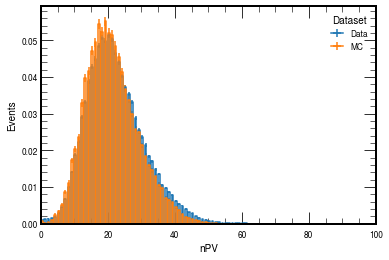

In [18]:
scales = output['nPV'].integrate("nPV").values()
scales['Data'] = 1/scales['Data',]
scales['MC'] = 1/scales['MC',]
del scales['Data',]
del scales['MC',]
output['nPV'].scale(scales, axis='dataset')

ax = hist.plot1d(output['nPV'], overlay='dataset')

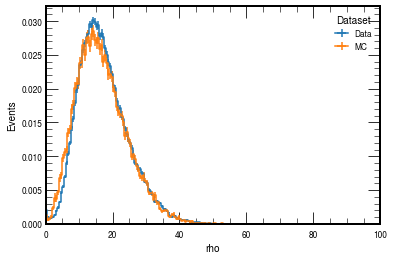

In [19]:
scales = output['rho'].integrate("rho").values()
scales['Data'] = 1/scales['Data',]
scales['MC'] = 1/scales['MC',]
del scales['Data',]
del scales['MC',]
output['rho'].scale(scales, axis='dataset')

ax = hist.plot1d(output['rho'], overlay='dataset')

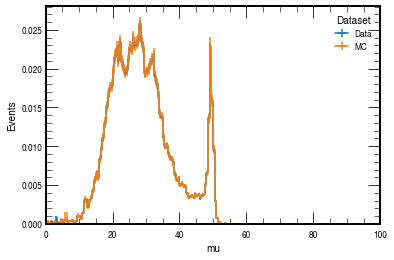

In [20]:
ax = hist.plot1d(output['nPU'], overlay='dataset')

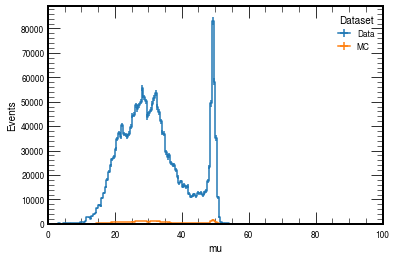

In [21]:
ax = hist.plot1d(output['p_nPV_nPU'], overlay='dataset')



<Hist (nPU) instance at 0x7f6491595150>
{(): array([2.0000e+00, 1.8000e+01, 7.0000e+00, 5.2000e+01, 2.8000e+01,
       6.2000e+01, 1.8800e+02, 4.5000e+01, 7.6000e+01, 1.5800e+02,
       9.6000e+01, 2.0400e+02, 3.1900e+02, 1.1400e+02, 2.0900e+02,
       2.2600e+02, 1.9100e+02, 1.6900e+02, 2.6300e+02, 7.3400e+02,
       7.8700e+02, 5.5600e+02, 1.2090e+03, 2.7640e+03, 2.6740e+03,
       2.0410e+03, 3.0910e+03, 3.8100e+03, 4.6160e+03, 6.2950e+03,
       7.6890e+03, 7.3940e+03, 1.0677e+04, 1.2727e+04, 1.5129e+04,
       1.8024e+04, 2.1421e+04, 2.4031e+04, 2.6378e+04, 2.7362e+04,
       3.0585e+04, 3.4793e+04, 3.7254e+04, 3.5354e+04, 4.0348e+04,
       3.6900e+04, 3.6531e+04, 3.5614e+04, 3.6961e+04, 3.9779e+04,
       4.4248e+04, 4.4640e+04, 4.8640e+04, 4.6943e+04, 4.8536e+04,
       5.0020e+04, 5.5609e+04, 5.1802e+04, 5.0100e+04, 4.3730e+04,
       4.5250e+04, 4.6747e+04, 4.9186e+04, 5.1439e+04, 5.3442e+04,
       4.7826e+04, 4.5720e+04, 4.1939e+04, 3.7232e+04, 3.6793e+04,
       2.9277e+04

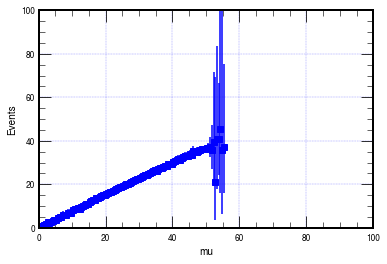

In [35]:
num = output['p_nPV_nPU'].integrate('dataset','Data') 
print(num)
#print(num.identifiers('nPU'))
print(num.values())
denom = output['nPU'].integrate('dataset','Data') 
print(denom)
print(denom.values())
#print(denom.identifiers('nPU'))

print(num.identifiers('nPU') == denom.identifiers('nPU'))
x = hist.plotratio(num, denom, unc='num', error_opts={'color': 'blue', 'marker': 's'},)
x.set_xlim(0, 100)
x.set_ylim(0, 100)
x.grid(color='b', ls = '-.', lw = 0.25)

121329.0


/eos/user/g/gagarwal/.local/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


Text(0, 0.5, '$<p_{T,offset}(\\pi \\times 0.4^{2})> / <\\mu>$')

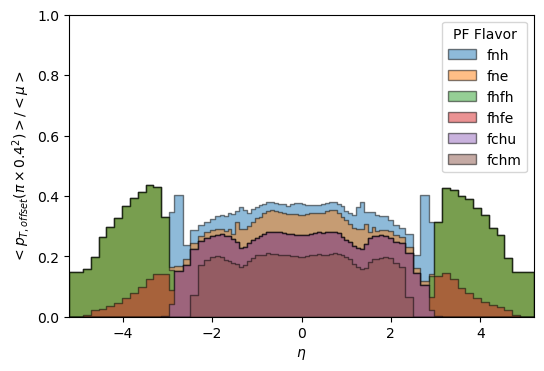

In [30]:
mu_range = slice(30,31)
mu_av = 0.5*(mu_range.stop+mu_range.start)
offset_multidim = output['p_mikko_eta_nPU_flavor'].integrate('dataset','Data')
offset_vs_eta_all = offset_multidim.integrate("nPU",mu_range)
norm = output['nPU'].integrate("dataset","Data").integrate("nPU",mu_range).values()[()] * mu_av 
print(norm)
offset_vs_eta_all.scale(1/norm)
offset_vs_eta = offset_vs_eta_all.remove(["flep","funtrk"],"flavor")
ax = hist.plot1d(offset_vs_eta, overlay='flavor', stack=True, fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3)})
ax.set_ylim(0., 1.0)
ax.set_xlim(-5.2, 5.2)
ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r"$<p_{T,offset}(\pi \times 0.4^{2})> / <\mu>$")

## Offset for CHM

(-5.2, 5.2)

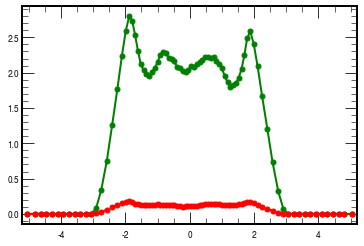

In [37]:
i=30
pid = 0
plt.plot(etaC,output['offsetpT_eta_nPU']['Data'][pid][i]/(i*output['RC_nEvents']['Data'][i]), 'go-', linewidth=2, markersize=5)
plt.plot(etaC,output['offsetpT_eta_nPU']['MC'][pid][i]/(i*output['RC_nEvents']['MC'][i]), 'ro--', linewidth=2, markersize=5)
plt.xlim(-5.2,5.2)

(8, 100, 82)
82
(82,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
{('MC',): 86.47826086956499, ('Data',): 3978.0}
86.47826086956499


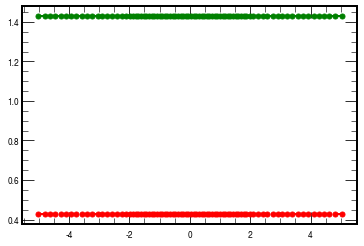

In [117]:
pid = 4


i=0
x = output['offsetpT_geo_eta_nPU']['Data']
print(x.shape)
xx = output['offsetpT_geo_eta_nPU']['Data'][pid][i]
print(len(xx))
print(xx.shape)
print(xx)

i=7
xx = output['offsetpT_geo_eta_nPU']['Data'][pid][i]
print(xx)

n = output['nPU'].integrate("nPU", slice(30,31)).values()
print(n)
print(n[('MC'),])
#plt.plot(etaC,output['offsetpT_geo_eta_nPU']['Data'][pid][i]/(i*n[('Data'),]), 'go-', linewidth=2, markersize=5)
#plt.plot(etaC,output['offsetpT_geo_eta_nPU']['MC'][pid][i]/(i*n[('MC'),]), 'ro--', linewidth=2, markersize=5)
plt.plot(etaC,output['offsetpT_geo_eta_nPU']['Data'][pid][i]/(i), 'go-', linewidth=2, markersize=5)
plt.plot(etaC,output['offsetpT_geo_eta_nPU']['MC'][pid][i]/(i), 'ro--', linewidth=2, markersize=5)
#plt.xlim(-5.2,5.2)

(-5.2, 5.2)

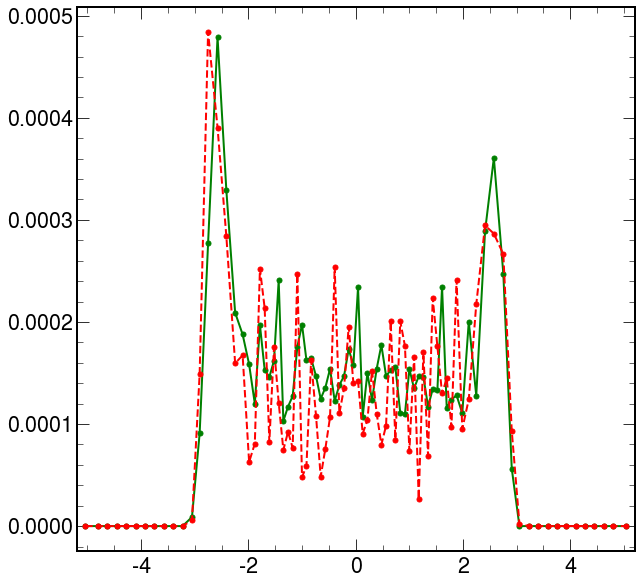

In [74]:
i=30
plt.plot(etaC,output['offsetpT_geo_eta_nPU']['Data'][1][i]/(i*output['RC_nEvents']['Data'][i]), 'go-', linewidth=2, markersize=5)
plt.plot(etaC,output['offsetpT_geo_eta_nPU']['MC'][1][i]/(i*output['RC_nEvents']['MC'][i]), 'ro--', linewidth=2, markersize=5)
plt.xlim(-5.2,5.2)

## Offset for CHU

(-5.2, 5.2)

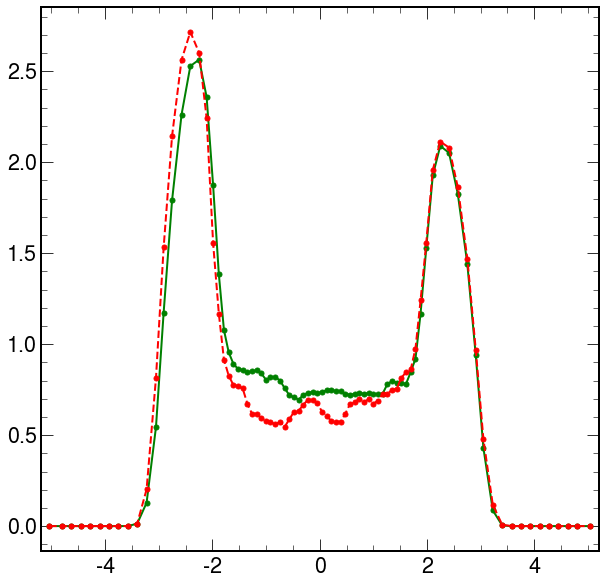

In [75]:
i=30
pid = 1
plt.plot(etaC,output['offsetpT_eta_nPU']['Data'][pid][i]/(i*output['RC_nEvents']['Data'][i]), 'go-', linewidth=2, markersize=5)
plt.plot(etaC,output['offsetpT_eta_nPU']['MC'][pid][i]/(i*output['RC_nEvents']['MC'][i]), 'ro--', linewidth=2, markersize=5)
plt.xlim(-5.2,5.2)

(-5.2, 5.2)

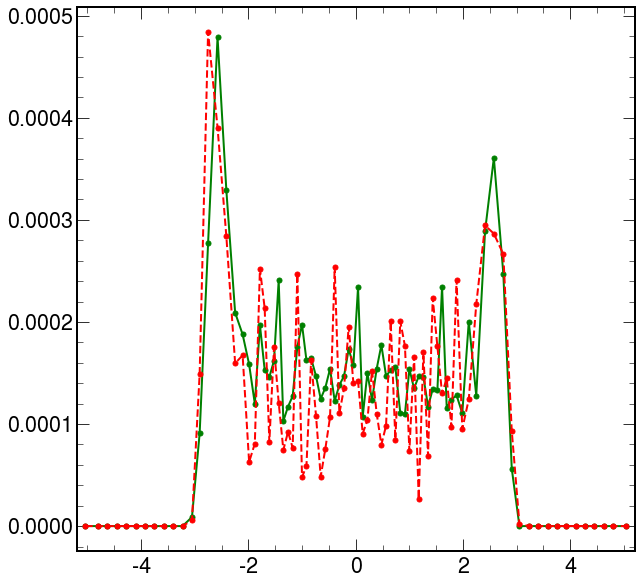

In [76]:
i=30
pid = 1
plt.plot(etaC,output['offsetpT_geo_eta_nPU']['Data'][pid][i]/(i*output['RC_nEvents']['Data'][i]), 'go-', linewidth=2, markersize=5)
plt.plot(etaC,output['offsetpT_geo_eta_nPU']['MC'][pid][i]/(i*output['RC_nEvents']['MC'][i]), 'ro--', linewidth=2, markersize=5)
plt.xlim(-5.2,5.2)